# COGS 108 - Data Checkpoint

# Names

- Dina Dehaini
- Cody Maheu
- Ryan Jackson
- Lauren Taylor
- Andrew Karafilis Tremaine

<a id='research_question'></a>
# Research Question

Can the wealth of a country determine whether their agricultural exports will be used as food (finalized goods for humans) or feed (raw product for consumption by animals to produce other goods)?

# Dataset(s)

**Dataset Name:** GDP (Current US$) **(GDP)**
 - **Link to Dataset:** https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2019&name_desc=false&start=1960
 - **Number of observations:** 265
 - **Description:** World Bank national accounts data, and OECD National Accounts data files of countries’ GDP.
     - **Timeline:** 1960-2019
     - Data are in current U.S. dollars

**Dataset Name:** Who eats the food we grow? **(FAO)**
 - **Link to Dataset:** https://www.kaggle.com/dorbicycle/world-foodfeed-production
 - **Number of observations:** 21,477
 - **Description:** “The Food and Agriculture Organization of the United Nations provides free access to food and agriculture data for over 245 countries and territories.” (https://www.kaggle.com/dorbicycle/world-foodfeed-production)  The dataset that we are interested in is the Food Balance Sheets. It has the data of a country's food supply during a specified reference period  specifically in our case food/feed.  
     - **Timeline:** 1961-2013
     - Food - refers to the quantity of the food item available as human food during the reference period.
     - Feed - refers to the quantity of the food item available for feeding to the livestock and poultry during the reference period.

**Combining Data**
 - The data will be merged together based on their country code (Area abbreviation in FAO, Country code in GDP). We will examine the data that cannot be merged by hand.



# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# GDP dataset
gdp = pd.read_csv("GDP.csv")

# Feed vs Food dataset (it's encoded in CP1252...)
fao = pd.read_csv("FAO.csv", encoding="latin1")

# All valid ISO-3166 country codes (for cleaning the GDP dataset)
with open("country_codes.txt", "r") as fh:
    country_codes = set(line[:-1] for line in fh)

# Data Cleaning

Describe your data cleaning steps here.
- The dataset has been read in from CSV files into our Dataframe objects for both FAO and GDP.
- We have begun the steps to begin to understand the data and figure out where our data outliers are coming from. (USA skews it heavily)
- The FAO dataset has no NAN values but GDP has NAN. We will need to understand where the NAN values are coming from.


In [2]:
# Dumping the columns for reference
gdp.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')

In [3]:
# Dumping the columns for reference
fao.columns

Index(['Area Abbreviation', 'Area Code', 'Area', 'Item Code', 'Item',
       'Element Code', 'Element', 'Unit', 'latitude', 'longitude', 'Y1961',
       'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967', 'Y1968', 'Y1969',
       'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975', 'Y1976', 'Y1977',
       'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983', 'Y1984', 'Y1985',
       'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993',
       'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000', 'Y2001',
       'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
       'Y2010', 'Y2011', 'Y2012', 'Y2013'],
      dtype='object')

In [4]:
# Remove any countries from the GDP dataset that isn't a valid country code.
# This includes a bunch of "total" rows that sum together multiple countries.
gdp_countries = set(gdp["Country Code"])
valid_countries = gdp_countries & country_codes
rows = gdp[[country in valid_countries for country in gdp["Country Code"]]][["Country Name", "2013"]]

# Show the top 10 countries by GDP in 2013.
rows.sort_values("2013", ascending=False).head(n=10)

Country Name          2013
249       United States  1.678485e+13
38                China  9.570406e+12
117               Japan  5.155717e+12
53              Germany  3.732743e+12
75               France  2.811078e+12
79       United Kingdom  2.786023e+12
27               Brazil  2.472807e+12
200  Russian Federation  2.292473e+12
114               Italy  2.141315e+12
107               India  1.856722e+12

In [5]:
# Largest and smallest GDPs in 2013.
rows["2013"].agg(["min", "max"])

min    3.750908e+07
max    1.678485e+13
Name: 2013, dtype: float64

<AxesSubplot:xlabel='2013', ylabel='Density'>

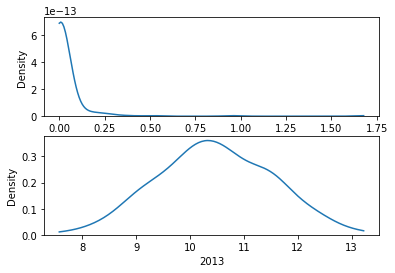

In [6]:
# Normal and log-scale plots of the distribution of GDP
# Average is a "10 figure" GDP from reading the log plot
_, (normal, log) = plt.subplots(2)

sns.kdeplot(rows["2013"], cut=0, ax=normal)
sns.kdeplot(np.log10(rows["2013"]), cut=0, ax=log)

<AxesSubplot:xlabel='Total', ylabel='Density'>

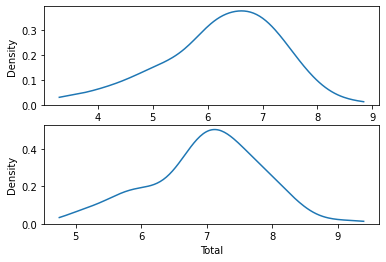

In [7]:
# Log-scale plots of the distribution of total feed exported and total food exported in 2013
# Measured in tons
totals = fao.groupby(["Area", "Element"])["Y2013"].sum().reset_index(name="Total")
totals["Total"] *= 1000

_, (feed, food) = plt.subplots(2)
sns.kdeplot(np.log10(totals[(totals["Element"] == "Feed") & (totals["Total"] > 0)]["Total"]), cut=0, ax=feed)
sns.kdeplot(np.log10(totals[totals["Element"] == "Food"]["Total"]), cut=0, ax=food)

In [8]:
# All countries that exported no feed in 2013
totals[totals["Total"] <= 0]

Area Element  Total
8      Antigua and Barbuda    Feed      0
66        China, Macao SAR    Feed      0
92                Djibouti    Feed      0
170               Kiribati    Feed      0
196               Maldives    Feed      0
260                 Rwanda    Feed      0
262  Saint Kitts and Nevis    Feed      0
270  Sao Tome and Principe    Feed      0
284        Solomon Islands    Feed      0

In [10]:
# Largest and smallest feed export in 2013.
totals[totals["Element"] == "Feed"]["Total"].agg(["min", "max"])

min            0
max    691903000
Name: Total, dtype: int64

In [11]:
# Largest and smallest food export in 2013.
totals[totals["Element"] == "Food"]["Total"].agg(["min", "max"])

min         56000
max    2499252000
Name: Total, dtype: int64

# Project Proposal (updated)

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/11  | 4 PM  | Checkpoint 1 Review | Wrangle data |
| 2/14  | 2 PM  | EDA stuff | start checkpoint 2 |
| 2/17  | 4 PM  | prep checkpoint 2 turnin | turn checkpoint 2 in |